In [1]:
import math
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l

In [2]:
# 基于位置的前馈网络
# 基于位置的前馈网络对序列中的所有位置的表示进行交换时使用的是同一个多层感知机，这就是称前馈网络是基于位置（positionwise）的原因。在下面的视线中，输入X的形状（批量大小，时间步数或序列长度，隐藏单元数或特征维度）将被一个两层的感知机转换成形状为（批量大小，时间步数，ffn_num_outputs）的输出张量。

In [3]:
class PositionWiseFFN(nn.Module):
    """基于位置的前馈网络"""
    def __init__(self, ffn_num_input, ffn_num_hiddens, ffn_num_outputs, **kwargs):
        super(PositionWiseFFN, self).__init__(**kwargs)
        self.dense1 = nn.Linear(ffn_num_input, ffn_num_hiddens)
        self.relu = nn.ReLU()
        self.dense2 = nn.Linear(ffn_num_hiddens, ffn_num_outputs)

    def forward(self, X):
        return self.dense2(self.relu(self.dense1(X)))

In [4]:
# 下面的例子显示，改变张量的最里层维度的尺寸(ffn_num_outputs)，会改变成基于位置的前馈网络的输出尺寸。因为用同一个多层感知机对所有位置上的输入进行变换，所以当所有这些位置的输入相同时，它们的输出也是相同的。

In [5]:
ffn = PositionWiseFFN(4, 4, 8)
ffn.eval()
ffn(torch.ones((2, 3, 4)))[0]

tensor([[-0.2981, -0.2761,  0.0845,  0.0618,  0.1592, -0.0680,  0.5018,  0.0916],
        [-0.2981, -0.2761,  0.0845,  0.0618,  0.1592, -0.0680,  0.5018,  0.0916],
        [-0.2981, -0.2761,  0.0845,  0.0618,  0.1592, -0.0680,  0.5018,  0.0916]],
       grad_fn=<SelectBackward0>)

In [6]:
# 残差连结和层规范化
# 前面解释了在一个小批量的样本内基于批量规范化对数据进行重新中心化和重新缩放的调整。层规范化和批量规范化的目标相同，但层规范化是基于特征维度进行规范化。尽管批量规范化在计算机视觉中被广泛应用，但在自然语言处理任务重（输入通常是变长序列）批量规范化通常不如层规范化的效果好。

In [7]:
# 一下代码对比不同维度的层规范化和批量规范化的效果
ln = nn.LayerNorm(2)
bn = nn.BatchNorm1d(2)
X = torch.tensor([[1, 2], [2, 3]], dtype=torch.float32)
# 在训练模式下计算X的均值和方差
print('layer norm:', ln(X), '\nbatch norm:', bn(X))

layer norm: tensor([[-1.0000,  1.0000],
        [-1.0000,  1.0000]], grad_fn=<NativeLayerNormBackward0>) 
batch norm: tensor([[-1.0000, -1.0000],
        [ 1.0000,  1.0000]], grad_fn=<NativeBatchNormBackward0>)


In [8]:
# 现在可以使用残差连结和层规范化来实现AddNorm类。暂退法也被作为正则化方法使用
class AddNorm(nn.Module):
    """残差连结后进行层规范化"""
    def __init__(self, normlized_shape, dropout, **kwargs):
        super(AddNorm, self).__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)
        self.ln = nn.LayerNorm(normlized_shape)

    def forward(self, X, Y):
        return self.ln(self.dropout(Y) + X)

In [9]:
# 残差连接要求两个输入的形状相同，以便假发操作后输出张量的形状相同
add_norm = AddNorm([3, 4], 0.5)
add_norm.eval()
res = add_norm(torch.ones((2, 3, 4)), torch.ones((2, 3, 4)))

In [10]:
res

tensor([[[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]],

        [[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]]], grad_fn=<NativeLayerNormBackward0>)

In [11]:
res.shape

torch.Size([2, 3, 4])

In [12]:
# 编码器
# 有了组成Transformer编码器的基础组件，现在可以先实现编码器中的一个层。下面的EncoderBlock类包含两个子层：多头注意力和基于位置的前馈网络，这两个子层都使用了残差连结和紧随的层规范化
class EncoderBlock(nn.Module):
    """Transformer编码器块"""
    def __init__(self, key_size, query_size, value_size, num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens, num_heads, dropout, use_bias=False, **kwargs):
        super(EncoderBlock, self).__init__(**kwargs)
        self.attention = d2l.MultiHeadAttention(
            key_size, query_size, value_size, num_hiddens, num_heads, dropout, use_bias
        )
        self.addnorma1 = AddNorm(norm_shape, dropout)
        self.ffn = PositionWiseFFN(
            ffn_num_input, ffn_num_hiddens, num_hiddens)
        self.addnorm2 = AddNorm(norm_shape, dropout)

    def forward(self, X, valid_lens):
        Y = self.addnorma1(X, self.attention(X, X, X, valid_lens))
        return self.addnorm2(Y, self.ffn(Y))

In [13]:
# 正如从代码中看到的，Transformer编码器中的任何层都不会改变其输入的形状
X = torch.ones((2, 100, 24))
valid_lens = torch.tensor([3, 4])
encoder_blk = EncoderBlock(24, 24, 24, 24, [100, 24], 24, 48, 8, 0.5)
encoder_blk.eval()
encoder_blk(X, valid_lens).shape

torch.Size([2, 100, 24])

In [14]:
# 下面实现的Transformer编码器的代码中，堆叠了num_layers个EncoderBlock类的实例，由于这里使用的是值范围在-1和1之间的固定位置编码，因此通过学习得到的输入的嵌入表示的值需要先乘以嵌入维度的平方根进行重新缩放，然后再与位置编码相加。 因为嵌入表示的值过小，这里进行缩放可以达到-1,1之间，这样，模型就不会被位置信息影响太多。

In [15]:
class TransformerEncoder(d2l.Encoder):
    """Transformer编码器"""
    def __init__(self, vocab_size, key_size, query_size, valud_size, num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens, num_heads, num_layers, dropout, use_bias=False, **kwargs):
        super(TransformerEncoder, self).__init__(**kwargs)
        self.num_hiddens = num_hiddens
        # 经过线性变换后的输入，维度为num_hiddens
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pow_encoding = d2l.PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_layers):
            self.blks.add_module('block' + str(i),
                                 EncoderBlock(key_size, query_size, valud_size, num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens, num_heads, dropout, use_bias))

    def forward(self, X, valid_lens, *args):
        # 因为位置编码在-1和1之间
        # 因此嵌入值乘以嵌入维度的平方根进行缩放
        # 然后再与位置编码相加
        X = self.pow_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        self.attention_weights = [None] * len(self.blks)
        for i, blk in enumerate(self.blks):
            X = blk(X, valid_lens)
            self.attention_weights[i] = blk.attention.attention.attention_weights
        return X


In [16]:
# 下面我们指定了超参数来创建一个两层的Transformer编码器。Transformer编码器输出的形状是(批量大小，时间步数目，num_hiddens)
encoder = TransformerEncoder(
    200, 24, 24, 24, 24, [100, 24], 24, 48, 8, 2, 0.5)
encoder.eval()
encoder(torch.ones((2, 100), dtype=torch.long), valid_lens).shape

torch.Size([2, 100, 24])

In [17]:
# 解码器，Transformer解码器也是由多个相同的层组成。在DecoderBloke类中实现的每个层包含了三个子层：解码器注意力、‘’编码器-解码器“注意力和基于位置的前馈网络。这些子层也都被残差连接和紧随的层规范化围绕。正如在本节前面所述 ，在掩蔽多头解码器自注意力层（第一个层）中，查询、键和值都来自上一个解码器层的输出。关于序列到序列模型，在训练阶段，其输出序列的所有位置（时间步）的词元都是已知的；然而，在预测阶段，其输出序列的词元是逐个生成的。因此，在任何解码器时间步中，只有生成的词元才能用于解码器的自注意力计算中。为了在解码器中保留自回归的属性，其掩蔽自注意力设定了参数dec_valid_lens, 以便任何查询都只会与解码器中所有已生成词元的位置（即直到该查询位置为止）进行注意力计算。elegant

In [35]:
class DecoderBlock(nn.Module):
    """解码器中地i个块"""
    def __init__(self, key_size, query_size, value_size, num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens, num_heads, dropout, i, **kwargs):
        super(DecoderBlock, self).__init__(**kwargs)
        self.i = i
        self.attention1 = d2l.MultiHeadAttention(key_size, query_size, value_size, num_hiddens, num_heads, dropout)
        self.attention2 = d2l.MultiHeadAttention(key_size, query_size, value_size, num_hiddens, num_heads, dropout)
        self.addnorm1 = AddNorm(norm_shape, dropout)
        self.addnorm2 = AddNorm(norm_shape, dropout)
        self.ffn = PositionWiseFFN(ffn_num_input, ffn_num_hiddens, num_hiddens)
        self.addnorm3 = AddNorm(norm_shape, dropout)

    def forward(self, X, state):
            enc_outputs, enc_valid_lens = state[0], state[1]
            # 训练阶段，输出序列的所有词元都在同一时间处理，因此state[2][self.i]初始化为None。
            # 预测阶段，输出序列是通过词元一个接着一个解码的，因此state[2][self.i]包含着直到当前时间步第i个块解码的输出表示
            if state[2][self.i] is None:   # 训练阶段
                key_values = X
            else:                          # 预测阶段
                key_values = torch.cat((state[2][self.i], X), axis=1)
            state[2][self.i] = key_values
            if self.training:
                # 训练阶段所有词元是可见的，因此要把当前时间步后的词给mask掉，
                # 以此来保留自回归的属性
                batch_size, num_steps, _ = X.shape
                # dec_valid_lens的开头：（batch_size, num_steps）,其中每一行是[1, 2, ...., num_steps]
                dec_valid_lens = torch.arange(1, num_steps+1, device=X.device).repeat(batch_size, 1)
            else:
                dec_valid_lens = None
            # 自注意力
            X2 = self.attention1(X, key_values, key_values, dec_valid_lens)
            Y = self.addnorm1(X, X2)
            # 编码器-解码器注意力
            # enc_outputs的开头：（batch_size, num_steps, num_hiddens）
            Y2 = self.attention2(Y, enc_outputs, enc_outputs, enc_valid_lens)
            Z = self.addnorm2(Y, Y2)
            return self.addnorm3(Z, self.ffn(Z)), state

In [29]:
torch.arange(1, 10+1, device=X.device).repeat(5, 1)

tensor([[ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10],
        [ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10],
        [ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10],
        [ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10],
        [ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]])

In [30]:
# 为了便于在“编码器-解码器”注意力中进行缩放点积计算和残差链接中进行加法计算，编码器和解码器的特征维度都是num_hiddens
decoder_blk = DecoderBlock(24, 24, 24, 24, [100, 24], 24, 48, 8, 0.5, 0)
decoder_blk.eval()
X = torch.ones((2, 100, 24))
state = [encoder_blk(X, valid_lens), valid_lens, [None]]
decoder_blk(X, state)[0].shape

torch.Size([2, 100, 24])

In [31]:
# 现在我们构建了由num_layers个DecoderBlock实例组成的完成的Transformer解码器。最后，通过一个全链接层来计算所有vocab_size个可能的输出词元的预测值。解码器的自注意力权重和编码器注意力权重都被存储下来，方便日后可视化的需要。

In [32]:
class TransformerDecoder(d2l.AttentionDecoder):
    def __init__(self, vocab_size, key_size, query_size, value_size, num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens, num_heads, num_layers, dropout, **kwargs):
        super(TransformerDecoder, self).__init__(**kwargs)
        self.num_hiddens = num_hiddens
        self.num_layers = num_layers
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = d2l.PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_layers):
            self.blks.add_module("block"+str(i),
                                 DecoderBlock(key_size, query_size, value_size, num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens, num_heads, dropout, i))
        self.dense = nn.Linear(num_hiddens, vocab_size)

    def init_state(self, enc_outputs, enc_valid_lens, *args):
        return [enc_outputs, enc_valid_lens, [None]*self.num_layers]

    def forward(self, X, state):
        X = self.pos_encoding(self.embedding(X)*math.sqrt(self.num_hiddens))
        self._attention_weights = [[None] * len(self.blks) for _ in range(2)]
        for i, blk in enumerate(self.blks):
            X, state = blk(X, state)
            # 解码器自注意力权重
            self._attention_weights[1][i] = blk.attention2.attention.attention_weights
            # 编码器-解码器自注意力权重
            self._attention_weights[1][i]=blk.attention2.attention.attention_weights
        return self.dense(X), state

    @property
    def attention_weights(self):
        return self._attention_weights


In [33]:
# 依照Transformer架构来实例化编码器-解码器模型。在这里，制定Transformer的编码器和解码器都是2层，都使用4头注意力。为了进行序列到序列的学习，下面在“英语-法语”机器翻译数据集上训练Transformer模型。

loss 0.030, 24565.5 tokens/sec on cuda:0


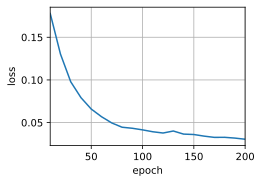

In [36]:
num_hiddens, num_layers, dropout, batch_size, num_steps = 32, 2, 0.1, 64, 10
lr, num_epochs, device = 0.005, 200, d2l.try_gpu()
ffn_num_input, ffn_num_hiddens, num_heads = 32, 64, 4
key_size, query_size, value_size = 32, 32, 32
norm_shape = [32]

train_iter, src_vocab, tgt_vocab = d2l.load_data_nmt(batch_size, num_steps)

encoder = TransformerEncoder(
    len(src_vocab), key_size, query_size, value_size, num_hiddens,
    norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
    num_layers, dropout)
decoder = TransformerDecoder(
    len(tgt_vocab), key_size, query_size, value_size, num_hiddens,
    norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
    num_layers, dropout)
net = d2l.EncoderDecoder(encoder, decoder)
d2l.train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)


In [ ]:
t